# Performing one reconstruction test
## using FEM+CG and/or ROM+CG

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('Utils/')
from Inverse_Util import inverse_obj, draw_this, inv_error, inv_n_norm, sparse_matrix
from Image_Util import img2arr, noise, res2heatmap, getAnimation
from Inverse_CG_Util import CG_FEM_solver, CG_ROM_solver, Solve_lam
import numpy as np
import pandas as pd
from ngsolve import *
import matplotlib as plt

plt.rc('xtick', labelsize=14)  
plt.rc('ytick', labelsize=14)
%reload_ext autoreload

def get_X(the_h, n, path, sqxN = 1, showSou = False, dt = 1/32):
    #exact letter source input
    sou = img2arr(path, checkGray = False, checkBw = False, sqxN = sqxN)
    #struct for forward solving
    X_fem = inverse_obj(h = the_h, order = 1, dim = 1, boundary = "bottom|left|right|top", 
                    T = 1, dt = dt, u0 = 0, source = sou, sqr = True)
    X_fem.get_mesh(sqxN)
    out_tmp = X_fem.solve_fem(save = True, anim = True)
    ## for sol animation
    out = noise(out_tmp[:,-1],level = 0.1, std = 1e-3)
    X_fem.fem_uT = out

    #displays the exact source
    if showSou:
        res2heatmap(sou, n, sqxN*n, sqxN)
    return X_fem, out_tmp, sou

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CG Solver for the Inverse Source Problem
- $u_0 = 0$
- Initial guess $f_0 = Sin(\pi x) \cdot Sin(\pi y)$
- Regularization $\lambda = 10^{-6}$, tolerance = $10^{-7}$
- Or $\lambda = 10^{-7}$, tolerance = $10^{-8}$
- h = 1/32, 1/64, 1/128, 1/256, 1/512
- $\Delta t$ = h
- T = 1
- noise on observation = Gaussian($0, 10^{-3}$) , level = 10%

In [5]:
nn = [2**5, 2**6, 2**7, 2**8, 2**9] #0 = 32, 4 = 512
idx = 3
h = 1/nn[idx]
the_lam = 1e-6
the_tol = 1e-7
f0 = sin(pi*x)*sin(pi*y)
path = "Letters/A{}.png".format(nn[idx])
#path = "heart/tartan256.png"
sqx = 1

X_fem, out_tmp, sou = get_X(h, nn[idx], path, sqx, False, dt = h)
ks = []; tms = []; errs = []; n_errs = []; resis = []; n_resis = [] 

mesh size:  (256, 256)


In [ ]:
sol = 'rom'
lam, count, f, [resi, n_resi] = Solve_lam(X_fem, f0, tol1 = 1e-7, tol2 = 1e-7, 
                                solver = sol, out = True)
err = inv_error(X_fem, sou, f)
n_err = inv_n_norm(X_fem, sou-f)
if sol == 'rom':
    print ("\nCG-ROM lam:", lam)
    print ("CG-ROM L2-error:", err)
    print ("CG-ROM n-error:", n_err)
    print ("CG-ROM L2-residual:", resi)
    print ("CG-ROM n-residual:", n_resi)
elif sol == 'fem':
    print ("\nCG-FEM lam:", lam)
    print ("CG-FEM L2-error:", err)
    print ("CG-FEM n-error:", n_err)
    print ("CG-FEM L2-residual:", resi)
    print ("CG-FEM n-residual:", n_resi)

In [ ]:
%matplotlib notebook
res2heatmap(X_fem.fem_uT, nn[idx], sqx*nn[idx], sqxN = sqx)
#getAnimation(out_tmp, nn[idx], sqx*nn[idx], fix = False, sqxN = sqx) #final time anim


CG-stdFEM used 0.616832971572876 sec
used 2 iterations
0.015625 1e-06 1e-07 2.0 0.616832971572876 0.4905535194677651


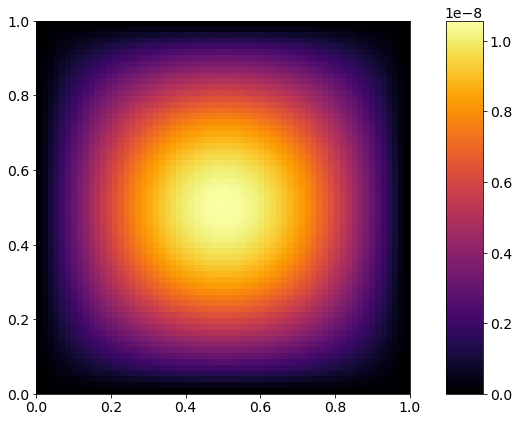


CG-FEM h & lam: 0.015625, 1e-06
CG-FEM L2-error: 0.4905535194677651
CG-FEM n-error: 0.4931166788019399
CG-FEM L2-residual: 0.017809341996730448
CG-FEM n-residual: 0.017540216531691244


In [57]:
#FEM test

for i in range(1):
    res_fem, k, tm = CG_FEM_solver(X_fem, f0, lam = the_lam,
                                   tol2 = the_tol, ite = True, ite_num = 0, 
                                   anim = True, star = False)
    err = inv_error(X_fem, sou, res_fem[-1])
    n_err = inv_n_norm(X_fem, sou-res_fem[-1])
    ks.append(k)
    tms.append(tm)
    errs.append(err)
    n_errs.append(n_err)
    m_mat = sparse_matrix(X_fem.m)
    X_fem.sou = m_mat@res_fem[-1]
    Sf0 = X_fem.solve_fem()
    resi0 = inv_error(X_fem, Sf0, X_fem.fem_uT)
    n_resi0 = inv_n_norm(X_fem, Sf0-X_fem.fem_uT)
    resis.append(resi0)
    n_resis.append(n_resi0)
    
k1 = np.mean(ks); tm1 = np.mean(tms); err1 = np.mean(errs); n_err1 = np.mean(n_errs)
resi1 = np.mean(resis); n_resi1 = np.mean(n_resis)
print(h,the_lam,the_tol,k1,tm1,err1)

res2heatmap(res_fem[-1], nn[idx], sqx*nn[idx], sqx)
print (f"\nCG-FEM h & lam: {h}, {the_lam}")
print ("CG-FEM L2-error:", err1)
print ("CG-FEM n-error:", n_err1)
print ("CG-FEM L2-residual:", resi1)
print ("CG-FEM n-residual:", n_resi1)

In [ ]:
getAnimation(res_fem, nn[idx], sqx*nn[idx], fix = True, sqxN = sqx) #reconstruct anim


CG-ROM used 0.7761209011077881 sec
used 20 iterations
0.015625 1e-06 1e-07 11.0 0.696476936340332 0.31941244697664806


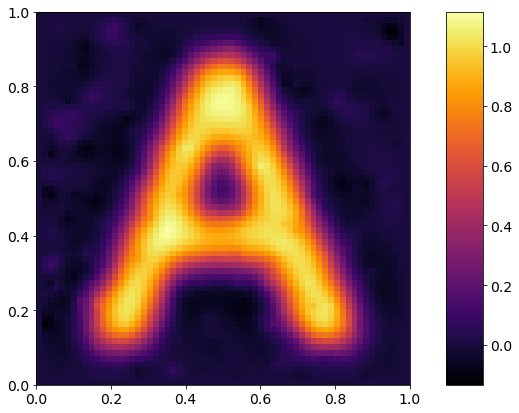


CG-ROM h & lam: 0.015625, 1e-06
CG-ROM L2-error: 0.31941244697664806
CG-ROM n-error: 0.3326296107177604
CG-ROM L2-residual: 0.009014290539442828
CG-ROM n-residual: 0.008926064649810939


In [58]:
#ROM test

for i in range(1):
    res_rom, k, tm = CG_ROM_solver(X_fem, f0, lam = the_lam,
                                  tol2 = the_tol, ite = True, anim = True, star = False)
    err = inv_error(X_fem, sou, res_rom[-1])
    n_err = inv_n_norm(X_fem, sou-res_rom[-1])
    ks.append(k)
    tms.append(tm)
    errs.append(err)
    n_errs.append(n_err)
    m_mat = sparse_matrix(X_fem.m)
    X_fem.sou = m_mat@res_rom[-1]
    Sf0 = X_fem.solve_fem()
    resi0 = inv_error(X_fem, Sf0, X_fem.fem_uT)
    n_resi0 = inv_n_norm(X_fem, Sf0-X_fem.fem_uT)
    resis.append(resi0)
    n_resis.append(n_resi0)
    
k1 = np.mean(ks); tm1 = np.mean(tms); err1 = np.mean(errs); n_err1 = np.mean(n_errs)
resi1 = np.mean(resis); n_resi1 = np.mean(n_resis)
print(h,the_lam,the_tol,k1,tm1,err1)

res2heatmap(res_rom[-1], nn[idx], sqx*nn[idx], sqx)
print (f"\nCG-ROM h & lam: {h}, {the_lam}")
print ("CG-ROM L2-error:", err1)
print ("CG-ROM n-error:", n_err1)
print ("CG-ROM L2-residual:", resi1)
print ("CG-ROM n-residual:", n_resi1)

<IPython.core.display.Javascript object>


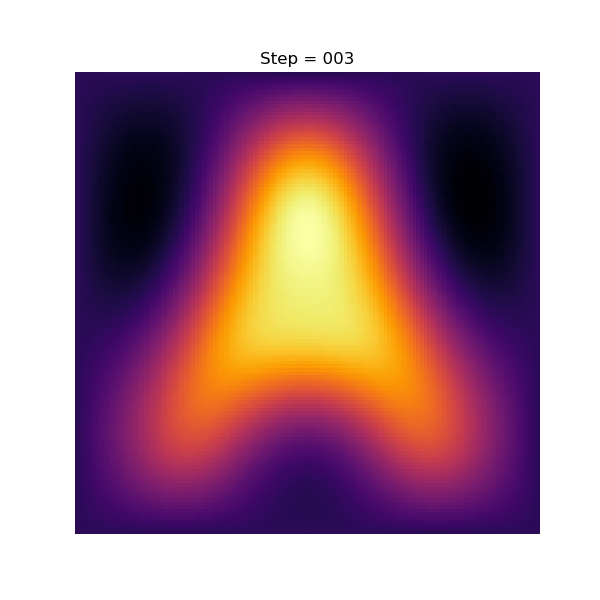

AttributeError: 'FuncAnimation' object has no attribute 'show'

In [21]:
getAnimation(res_rom, nn[idx], sqx*nn[idx], fix = True, sqxN = sqx) #reconstruct anim

In [ ]:
err_comp = inv_error(X_fem, res_fem[-1], res_rom[-1])
print ("\nCG-FEM CG,-ROM L2_comparison error:", err_comp)